In [9]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [10]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts

        # Aggregation function
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()
    
    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [11]:
# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []
    num_samples = min(len(dataset.labels), num_samples)

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = np.random.choice(len(dataset.labels), size=num_samples, replace=False)

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode')
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    plt.show()

In [13]:
model = YOLO("/home/areebadnan/Areeb_code/work/Atheritia/All_models/Large/coco_base_finetune_17logo_L.pt")

In [15]:
%pwd

'/home/areebadnan/Areeb_code/work/Atheritia/Scripts/Data-Preprocessing-for-Logo-Detection/weighted_dataloader'

In [16]:
results = model.train(data='/home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/data.yaml', freeze=14, epochs=500, imgsz=640, batch=-1, project='47_(10)_logos_head_17logosbase_L')

New https://pypi.org/project/ultralytics/8.3.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.4.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7721MiB)
engine/trainer: task=detect, mode=train, model=/home/areebadnan/Areeb_code/work/Atheritia/All_models/Large/coco_base_finetune_17logo_L.pt, data=/home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/data.yaml, epochs=500, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=47_(10)_logos_head_17logosbase_L, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=14, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, 

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.34MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU) 7.54G total, 0.38G reserved, 0.37G allocated, 6.78G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


/home/areebadnan/Areeb_Python_Environments/yolo_env2/lib/python3.10/site-packages/ultralytics/engine/trainer.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)


    43637550       165.4         0.608         17.34         36.94        (1, 3, 640, 640)                    list
    43637550       330.9         0.797         30.29         22.74        (2, 3, 640, 640)                    list
    43637550       661.8         1.160          46.7         26.19        (4, 3, 640, 640)                    list
    43637550        1324         1.864         96.11         32.96        (8, 3, 640, 640)                    list
    43637550        2647         3.278           200         67.78       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 20 for CUDA:0 4.75G/7.54G (63%) ✅


train: Scanning /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/labels.cache... 36016 images, 106 backgrounds, 0 corrupt: 100%|██████████| 36016/36016 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/images/62d5746b43918a4b047cfbe5_274.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/images/62d5746b43918a4b047cfbe5_275.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/images/62d5746b43918a4b047cfbe5_276.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/images/62d5746b43918a4b047cfbe5_277.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/train_comb/images/62d5746b43918a4b047cfbe5_278.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /h


/home/areebadnan/Areeb_Python_Environments/yolo_env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/areebadnan/Areeb_Python_Environments/yolo_env2/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /home/areebadnan/Areeb_code/work/Atheritia/Datasets/47_logos_dataset/10_classes_final/final/split2/test/labels.cache... 5592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5592/5592 [00:00<?, ?it/s]


Plotting labels to 47_(10)_logos_head_17logosbase_L/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00046875), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to 47_(10)_logos_head_17logosbase_L/train
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      4.24G      2.157      4.229      1.468        107        640:  15%|█▍        | 265/1801 [01:56<11:13,  2.28it/s]


KeyboardInterrupt: 

In [17]:
model.trainer.train_loader.dataset

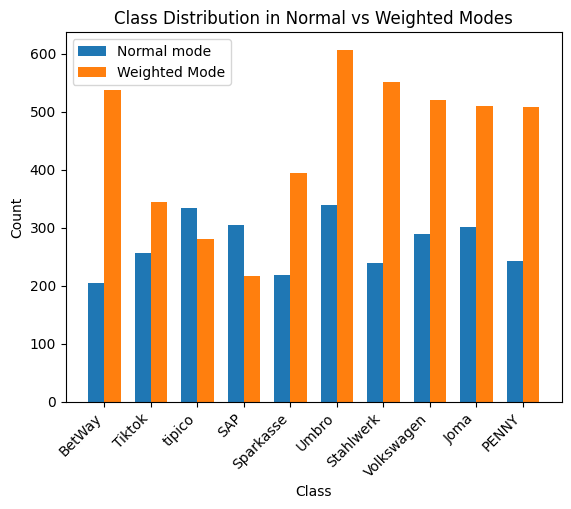

In [21]:
# You can test different aggregation functions np.max, np.sum, np.median, np.mean
model.trainer.train_loader.dataset.agg_func = np.sum
model.trainer.train_loader.dataset.weights = model.trainer.train_loader.dataset.calculate_weights()
model.trainer.train_loader.dataset.probabilities = model.trainer.train_loader.dataset.calculate_probabilities()

# Get class counts in weighted mode
model.trainer.train_loader.dataset.train_mode = True 
weighted_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Get class counts in default mode
model.trainer.train_loader.dataset.train_mode = False
default_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Plot the comparison
# Ensure inline plotting in Jupyter
%matplotlib inline
plot_class_balance(weighted_counts, default_counts, set(model.trainer.train_loader.dataset.data["names"].values()))



plt.show()